In [307]:
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.image as mpimg
import copy
from numba import jit, njit, vectorize, cuda, uint32, f8,uint8
import cupy as cp
import h5py
from PIL import Image

In [308]:
def load():
    directorio_cats = "/home/theTarnished/Desktop/theTarnished/AI/train/training_set/cats"
    directorio_dogs = "/home/theTarnished/Desktop/theTarnished/AI/train/training_set/dogs"
    directorio_cats_test = "/home/theTarnished/Desktop/theTarnished/AI/train/test_set-20231013T163722Z-001/test_set/cats"
    directorio_dogs_test = "/home/theTarnished/Desktop/theTarnished/AI/train/test_set-20231013T163722Z-001/test_set/dogs"
    
    archivos_cats = os.listdir(directorio_cats)
    L_cats = len(archivos_cats) // 4

    train = np.empty((0, 64, 64, 3))

    for i in range(L_cats):
        joinImage = os.path.join(directorio_cats, archivos_cats[i])
        charge = mpimg.imread(joinImage)
        imagereduce = cv2.resize(charge, (64, 64), interpolation=cv2.INTER_AREA)
        train = np.append(train, [imagereduce], axis=0)

    archivos_dogs = os.listdir(directorio_dogs)
    L_dogs = (len(archivos_dogs) // 4)-1

    for i in range(L_dogs):
        joinImage = os.path.join(directorio_dogs, archivos_dogs[i])
        charge = mpimg.imread(joinImage)
        imagereduce = cv2.resize(charge, (64, 64), interpolation=cv2.INTER_AREA)
        train = np.append(train, [imagereduce], axis=0)
        
    ones = np.ones((1000, 1))
    zeros = np.zeros((1000, 1))
    trainy = np.vstack((ones, zeros))
    random = train.shape[0]
    randomIndex = np.random.permutation(random)
    train = train[randomIndex]
    trainy = trainy[randomIndex]
    trainy = trainy.flatten()
    trainyInt = (trainy + 0.5).astype(int)
    trainy = np.array([trainyInt])


    archivos_cats_test = os.listdir(directorio_cats_test)
    L_cats_test = (len(archivos_cats_test))-11 

    test = np.empty((0, 64, 64, 3))

    for i in range(L_cats_test):
        joinImage_test = os.path.join(directorio_cats_test, archivos_cats_test[i])
        charge_test = mpimg.imread(joinImage_test)
        imagereduce_test = cv2.resize(charge_test, (64, 64), interpolation=cv2.INTER_AREA)
        test = np.append(test, [imagereduce_test], axis=0)
    archivos_dogs_test = os.listdir(directorio_dogs_test)
    L_dogs_test = (len(archivos_dogs_test))-12
    for i in range(L_dogs_test):
        joinImage_test = os.path.join(directorio_dogs_test, archivos_dogs_test[i])
        charge_test = mpimg.imread(joinImage_test)
        imagereduce_test = cv2.resize(charge_test, (64, 64), interpolation=cv2.INTER_AREA)
        test = np.append(test, [imagereduce_test], axis=0)
        
    ones = np.ones((1000, 1))
    zeros = np.zeros((1000, 1))
    testy = np.vstack((ones, zeros))
    random = test.shape[0]
    randomIndex = np.random.permutation(random)
    test = test[randomIndex]
    testy = testy[randomIndex]
    testy = testy.flatten()
    testyInt = (testy + 0.5).astype(int)
    testy = np.array([testy])

    
    classes = np.array([b'non-cat', b'cat'], dtype= '|S7')
    
    return train, trainy, test, testy, classes

In [309]:
def loadData():
    train_dataset = h5py.File('/home/theTarnished/Desktop/theTarnished/AI/train/train_catvnoncat.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:])
    train_set_y_orig = np.array(train_dataset["train_set_y"][:])  

    test_dataset = h5py.File('/home/theTarnished/Desktop/theTarnished/AI/train/test_catvnoncat.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) 
    test_set_y_orig = np.array(test_dataset["test_set_y"][:])

    classes = np.array(test_dataset["list_classes"][:]) 
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

In [310]:
def initparm(layerDim):
    np.random.seed(1)
    parameters = {}
    L = len(layerDim)
    
    for l in range(1, L):
        parameters["W" + str(l)] = np.random.randn(layerDim[l], layerDim[l-1])/ np.sqrt(layerDim[l-1])
        parameters["b" + str(l)] = np.zeros((layerDim[l],1))
    return parameters

In [311]:
def sigmoid(Z):
    cache = Z
    A = 1/(1+np.exp(-Z))
    return A, cache

In [312]:
def relu(Z):
    A = np.maximum(0,Z)
    cache = Z
    return A,cache

In [313]:
def dSigmoid(dA, cache):
    Z = cache 
    s = 1/(1+np.exp(-Z))
    dZ = dA * s * (1-s)
    return dZ

In [314]:
def dRelu(dA, cache):
    Z = cache
    dZ = np.array(dA, copy = True)
    dZ[Z<=0] = 0
    assert (dZ.shape == Z.shape)

    return dZ

In [315]:
def forward(A,W,b):
    Z = W.dot(A) + b
    cache = (A,W,b)
    return Z, cache

In [316]:
def actForward(Aprev, W, b, act):
    Z, linearCache = forward(Aprev,W,b)
    if act == "sigmoid":
        A, actCache = sigmoid(Z)
    elif act == "relu":
        A, actCache = relu(Z)

    cache = (linearCache,actCache)
    return A, cache

In [317]:
def deepForward(X, parameters):
    caches = []
    A = X
    L = len(parameters)//2
    for l in range(1,L):
        Aprev = A
        A, cache = actForward(Aprev, parameters["W" + str(l)], parameters["b" + str(l)], "relu")
        caches.append(cache)
    AL, cache = actForward(A, parameters["W" + str(L)], parameters["b" + str(L)], "sigmoid")
    caches.append(cache)
    return AL, caches

In [318]:
def computeCost(AL, Y):
    m = Y.shape[1]
    cost = (1./m) * (-np.dot(Y,np.log(AL).T) - np.dot(1-Y, np.log(1-AL).T))
    cost = np.squeeze(cost)
    return cost

In [319]:
def backward(dZ, cache):
    Aprev, W, b = cache
    m = Aprev.shape[1]
    dW = 1./m*np.dot(dZ, Aprev.T)
    db = 1./m*np.sum(dZ, axis = 1, keepdims=True)
    dAprev = np.dot(W.T, dZ)
    return dAprev, dW,db

In [320]:
def actBackward(dA, cache, act):
    linearCache, actCache = cache
    if act == "relu":
        dZ = dRelu(dA, actCache)
        dAprev, dW,db = backward(dZ, linearCache)
    if act == "sigmoid":
        dZ = dSigmoid(dA, actCache)
        dAprev, dW, db = backward(dZ, linearCache)
    return dAprev,dW,db

In [321]:
def deepBackward(AL, Y, cache):
    grads = {}
    L = len(cache)
    Y = Y.reshape(AL.shape)
    dAL = -(np.divide(Y,AL) - np.divide(1-Y, 1-AL))
    currentCache = cache[L-1]
    grads["dA" + str(L-1)], grads["dW" + str(L)],grads["db" + str(L)] = actBackward(dAL, currentCache, "sigmoid")
    
    for l in reversed(range(L-1)):
        currentCache = cache[l]
        grads["dA" + str(l)], grads["dW" + str(l+1)],grads["db" + str(l+1)] = actBackward(grads["dA" + str(l+1)], currentCache, "relu")
    return grads

In [322]:
def updateParams(params, grads, learningRate):
    L= len(params)//2
    for l in range(L):
        params["W" + str(l+1)] -= learningRate*grads["dW" + str(l+1)]
        params["b" + str(l+1)] -= learningRate*grads["db" + str(l+1)]
    return params

In [336]:
def predic(X,Y, parameters):
    m = X.shape[1]
    p = np.zeros((1,m))
    proba,caches = deepForward(X, parameters)

    for l in range(proba.shape[1]):
        if proba[0,l] > 0.5:
            p[0, l] = 1
        else:
            p[0,l] = 0
            
    print("Accuracy: "  + str(np.sum((p == Y)/m)))
    return p

In [324]:
def LLayermodel(X,Y, layerDims, learningRate = 0.0075, iter = 3000):
    np.random.seed(1)
    costs = []
    parameters = initparm(layerDims)
    for l in range(iter):
        AL, caches = deepForward(X,parameters)
        cost = computeCost(AL,Y)
        grads= deepBackward(AL, Y, caches)
        parameters= updateParams(parameters, grads, learningRate)
        if l % 100 == 0 or l == iter - 1:
            print("Cost after iteration {}: {}".format(l, np.squeeze(cost)))
        if l % 100 == 0 or l == iter:
            costs.append(cost)
    
    return parameters,costs

I still need to learn how to use the data and start training. Dr Erwin hero?

In [325]:
train_x_orig, train_y, test_x_orig, test_y, classes = loadData()

In [326]:
m_train = train_x_orig.shape[0]
num_px = train_x_orig.shape[1]
m_test = test_x_orig.shape[0]

print ("Number of training examples: " + str(m_train))
print ("Number of testing examples: " + str(m_test))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_x_orig shape: " + str(train_x_orig.shape))
print ("train_y shape: " + str(train_y.shape))
print ("test_x_orig shape: " + str(test_x_orig.shape))
print ("test_y shape: " + str(test_y.shape))

Number of training examples: 209
Number of testing examples: 50
Each image is of size: (64, 64, 3)
train_x_orig shape: (209, 64, 64, 3)
train_y shape: (1, 209)
test_x_orig shape: (50, 64, 64, 3)
test_y shape: (1, 50)


In [327]:
train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0], -1).T   # The "-1" makes reshape flatten the remaining dimensions
test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0], -1).T

train_x = train_x_flatten/255.
test_x = test_x_flatten/255.

print ("train_x's shape: " + str(train_x.shape))
print ("test_x's shape: " + str(test_x.shape))

train_x's shape: (12288, 209)
test_x's shape: (12288, 50)


In [328]:
layers_dims = [12288,25,5, 1]  
parameters, cost = LLayermodel(train_x,train_y, layers_dims, learningRate = 0.005, iter = 5000)

Cost after iteration 0: 0.6683497851097117
Cost after iteration 100: 0.531540810271629
Cost after iteration 200: 0.46261712822816925
Cost after iteration 300: 0.41414375904619133
Cost after iteration 400: 0.3775900746509522
Cost after iteration 500: 0.3437401410600824
Cost after iteration 600: 0.29775100229861445
Cost after iteration 700: 0.26352333221198965
Cost after iteration 800: 0.19947319417134468
Cost after iteration 900: 0.1560703890228815
Cost after iteration 1000: 0.10313222632500317
Cost after iteration 1100: 0.0810495749313932
Cost after iteration 1200: 0.06324018768318845
Cost after iteration 1300: 0.051276854171177555
Cost after iteration 1400: 0.04246577610987373
Cost after iteration 1500: 0.03570026802825601
Cost after iteration 1600: 0.030434320958399645
Cost after iteration 1700: 0.02625171802630902
Cost after iteration 1800: 0.02290184193769194
Cost after iteration 1900: 0.02015318490695778
Cost after iteration 2000: 0.017888444388497432
Cost after iteration 2100: 0.

In [337]:
pred_train = predic(train_x, train_y, parameters)

Accuracy: 0.9999999999999998


In [338]:
pred_test = predic(test_x, test_y, parameters)

Accuracy: 0.76


In [331]:
trainy.shape

(1, 2000)

In [332]:
trainx.shape[1]

2000

Accuracy: 1.0
y = 1.0, your L-layer model predicts a "cat" picture.


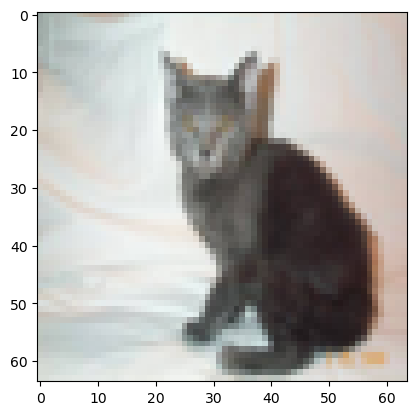

In [363]:
my_image = "cat.4014.jpg" 
my_label_y = [1] 

fname = "/home/theTarnished/Desktop/theTarnished/AI/train/test_set-20231013T163722Z-001/test_set/cats/" + my_image
image = np.array(Image.open(fname).resize((numPx, numPx)))
plt.imshow(image)
image = image / 255.
image = image.reshape((1, numPx * numPx * 3)).T

my_predicted_image = predic(image, my_label_y, parameters)


print ("y = " + str(np.squeeze(my_predicted_image)) + ", your L-layer model predicts a \"" + classes[int(np.squeeze(my_predicted_image)),].decode("utf-8") +  "\" picture.")

In [340]:
trainxOrigin, trainy, testxOrigin, testy, classes = load()

In [341]:
mTrain= trainxOrigin.shape[0]
numPx = trainxOrigin.shape[1]
mTest = testxOrigin.shape[0]
print ("Number of training examples: " + str(mTrain))
print ("Number of testing examples: " + str(mTest))
print ("Each image is of size: (" + str(numPx) + ", " + str(numPx) + ", 3)")
print ("train_x_orig shape: " + str(trainxOrigin.shape))
print ("train_y shape: " + str(trainy.shape))
print ("test_x_orig shape: " + str(testxOrigin.shape))
print ("test_y shape: " + str(testy.shape))

Number of training examples: 2000
Number of testing examples: 2000
Each image is of size: (64, 64, 3)
train_x_orig shape: (2000, 64, 64, 3)
train_y shape: (1, 2000)
test_x_orig shape: (2000, 64, 64, 3)
test_y shape: (1, 2000)


In [342]:
trainxFlatten = trainxOrigin.reshape(trainxOrigin.shape[0],-1).T
testxFlatten = testxOrigin.reshape(testxOrigin.shape[0],-1).T
trainx = trainxFlatten/255.
testx = testxFlatten/255.

In [354]:
layers_dims = [12288, 50, 25, 5, 1]
parameters, cost = LLayermodel(trainx,trainy, layers_dims, learningRate = 0.0075, iter = 5000)

Cost after iteration 0: 0.7089269457180424
Cost after iteration 100: 0.6568352624537601
Cost after iteration 200: 0.6430782193839194
Cost after iteration 300: 0.6293488042547172
Cost after iteration 400: 0.6119662787527684
Cost after iteration 500: 0.6047292513133918
Cost after iteration 600: 0.5954975612521605
Cost after iteration 700: 0.5815634410371806
Cost after iteration 800: 0.5727275358880949
Cost after iteration 900: 0.5683384345930199
Cost after iteration 1000: 0.5515326963371988
Cost after iteration 1100: 0.5405242306308815
Cost after iteration 1200: 0.5340746815848831
Cost after iteration 1300: 0.5253108567275893
Cost after iteration 1400: 0.5126792303012595
Cost after iteration 1500: 0.5007360290717109
Cost after iteration 1600: 0.470242615988177
Cost after iteration 1700: 0.5242998027008713
Cost after iteration 1800: 0.44582470203784563
Cost after iteration 1900: 0.4525752828075464
Cost after iteration 2000: 0.37213948232875255
Cost after iteration 2100: 0.5482960561942191

In [355]:
pred_train = predic(trainx, trainy, parametes)

Accuracy: 0.5


In [356]:
pred_test = predic(testx,testy, parameters)

Accuracy: 0.6045


Accuracy: 0.0
y = 0.0, your L-layer model predicts a "non-cat" picture.


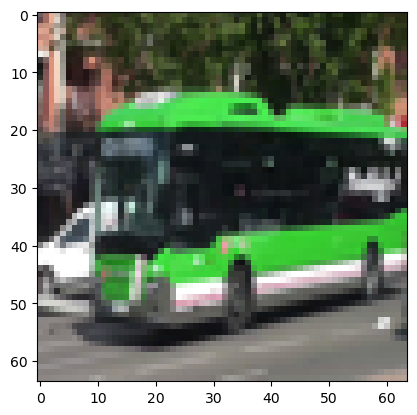

In [364]:
my_image = "WhatsApp Image 2023-09-19 at 11.35.05 PM.jpeg" 
my_label_y = [1] 

fname = "/home/theTarnished/Downloads/" + my_image
image = np.array(Image.open(fname).resize((numPx, numPx)))
plt.imshow(image)
image = image / 255.
image = image.reshape((1, numPx * numPx * 3)).T

my_predicted_image = predic(image, my_label_y, parameters)


print ("y = " + str(np.squeeze(my_predicted_image)) + ", your L-layer model predicts a \"" + classes[int(np.squeeze(my_predicted_image)),].decode("utf-8") +  "\" picture.")